<h2>Pick and Place with Vision</h2>

<br>Richiede 'sim.py', 'simConst.py', 'remoteapi.dll' all'interno della stessa cartella del notebook jupyter.</br> 
<br> La scena implementata per CoppeliaSim è: MTB_Pick_N_Place.ttt</br> 


In [81]:
# Importiamo le librerie necessarie
import sim          # libreria per connettersi con CoppeliaSim
import sympy as sp  # libreria per il calcolo simbolico
import time

### 0. Verifichiamo che tutto funzioni...

Il robot ha una ventosa all'estremità. Si attiva automaticamente quando ci si avvicina al cubo (1 mm o meno) e si disattiva quando il cubo viene posizionato sulla piattaforma (5 mm o meno).

In [82]:
def connect(port):
#Stabilire una connessione a VREP
#la porta deve corrispondere alla porta di connessione in VREP
#restituisce il numero del client o -1 se non riesce a stabilire una connessione
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID


In [83]:
def setEffector(val):
# Azione l'end-effector
# val è un Int con valore 0 o 1 per disabilitare o abilitare l'attuatore finale.
    res,retInts,retFloats,retStrings,retBuffer=sim.simxCallScriptFunction(clientID,
        "suctionPad", sim.sim_scripttype_childscript,"setEffector",[val],[],[],"", sim.simx_opmode_blocking)
    return res

In [84]:
# Abbiamo bisogno delle maniglie per le articolazioni e del manichino
clientID = connect(19999)

retCode,effector=sim.simxGetObjectHandle(clientID,'effector',sim.simx_opmode_blocking)
retCode,joint1=sim.simxGetObjectHandle(clientID,'MTB_joint1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'MTB_joint2',sim.simx_opmode_blocking)
retCode,joint3=sim.simxGetObjectHandle(clientID,'MTB_joint3',sim.simx_opmode_blocking)
retCode,joint4=sim.simxGetObjectHandle(clientID,'MTB_joint4',sim.simx_opmode_blocking)
retCode,cuboRosso=sim.simxGetObjectHandle(clientID,'CuboRosso',sim.simx_opmode_blocking)
retCode,cuboBlu=sim.simxGetObjectHandle(clientID,'CuboBlu',sim.simx_opmode_blocking)

print(effector, joint1, joint2, joint3, joint4, cuboRosso, cuboBlu)

conectado a 19999
33 17 20 23 26 35 36


In [85]:
# Inviamo le posizioni alle articolazioni
q = [0, 0, 0.0]

retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2], sim.simx_opmode_oneshot)


In [86]:
# Attiviamo o disattiviamo l'attuatore finale
setEffector(0)

0

###  1. Prepariamo le informazioni necessarie
Dalla matrice della cinematica diretta calcoliamo la cinematica inversa.

In [87]:
# 1. Las expresiones de cinemática directa

# En una actividad anterior se obtuvo la matriz de cinemática directa
# para el actuador final, como función de las posiciones de las articulaciones.

q1 = sp.symbols('q1') # angolo dell'articolazione rotazinale joint1, in radianti
q2 = sp.symbols('q2') # angolo dell'articolazione rotazinale joint2, in radiantis
q3 = sp.symbols('q3') # posizione dell'articolazione prismatica joint3, in metri
q4 = sp.symbols('q4') # angolo dell'articolazione rotazinale joint4, in radianti

T = sp.Matrix([[sp.cos(q1 + q2 + q4), -sp.sin(q1 + q2 + q4), 0, 0.467*sp.cos(q1) + 0.4005*sp.cos(q1 + q2)],
            [sp.sin(q1 + q2 + q4), sp.cos(q1 + q2 + q4), 0, 0.467*sp.sin(q1) + 0.4005*sp.sin(q1 + q2)], 
            [0, 0, 1, 0.234 - q3], 
            [0, 0, 0, 1]])
T

Matrix([
[cos(q1 + q2 + q4), -sin(q1 + q2 + q4), 0, 0.467*cos(q1) + 0.4005*cos(q1 + q2)],
[sin(q1 + q2 + q4),  cos(q1 + q2 + q4), 0, 0.467*sin(q1) + 0.4005*sin(q1 + q2)],
[                0,                  0, 1,                          0.234 - q3],
[                0,                  0, 0,                                   1]])

###  2. Otteniamo la posizione del punto di destinazione


In [88]:
def matrixFromPose(pose):
    # pose = [x, y, z, alpha, beta, gamma]
    # x, y, z en metros
    # alpha, beta, gamma en radianes
    x, y, z = pose[0], pose[1], pose[2]
    alpha, beta, gamma = pose[3], pose[4], pose[5]
    Ra = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    Rb = sp.Matrix([[sp.cos(beta), 0, sp.sin(beta), 0],
                   [0, 1, 0, 0],
                   [-sp.sin(beta), 0, sp.cos(beta), 0],
                   [0, 0, 0, 1]])
    Rc = sp.Matrix([[sp.cos(gamma), -sp.sin(gamma), 0, 0],
                   [sp.sin(gamma), sp.cos(gamma), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    T = Ra*Rb*Rc
    T[0,3] = x
    T[1,3] = y
    T[2,3] = z
    return T

# Definiamo una funzione per costruire la matrice di rotazione
# Partendo dagli angoli di Eulero

def matrixFromEuler(alpha, beta, gamma):
    # theta y alpha en radianes
    # d y a en metros
    Ra = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    Rb = sp.Matrix([[sp.cos(beta), 0, sp.sin(beta), 0],
                   [0, 1, 0, 0],
                   [-sp.sin(beta), 0, sp.cos(beta), 0],
                   [0, 0, 0, 1]])
    Rc = sp.Matrix([[sp.cos(gamma), -sp.sin(gamma), 0, 0],
                   [sp.sin(gamma), sp.cos(gamma), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    T = Ra*Rb*Rc
    return T

# Connettiti al server e ottieni handle
def getHandlers():
    retCode,effector=sim.simxGetObjectHandle(clientID,'effector',sim.simx_opmode_blocking)
    retCode,target=sim.simxGetObjectHandle(clientID,'CuboRosso',sim.simx_opmode_blocking)
    retCode,joint1=sim.simxGetObjectHandle(clientID,'MTB_joint1',sim.simx_opmode_blocking)
    retCode,joint2=sim.simxGetObjectHandle(clientID,'MTB_joint2',sim.simx_opmode_blocking)
    retCode,joint3=sim.simxGetObjectHandle(clientID,'MTB_joint3',sim.simx_opmode_blocking)
    retCode,joint4=sim.simxGetObjectHandle(clientID,'MTB_joint4',sim.simx_opmode_blocking)
    joint = [joint1, joint2, joint3, joint4]
    return joint, effector, target

In [89]:
matrixFromEuler(45*sp.pi/180, 0, 45*sp.pi/180)

Matrix([
[sqrt(2)/2, -sqrt(2)/2,          0, 0],
[      1/2,        1/2, -sqrt(2)/2, 0],
[      1/2,        1/2,  sqrt(2)/2, 0],
[        0,          0,          0, 1]])

In [90]:
# A partir de las coordenadas de posición y los ángulos de Euler
# es posible obtener la matriz de transformación

x = 0.0
y = 0.0
z = 0.0
alpha = 0
beta = 0
gamma = 45*sp.pi/180

t = sp.Matrix([[1, 0, 0, x],
               [0, 1, 0, y], 
               [0, 0, 1, z], 
               [0, 0, 0, 1]])

D = t*matrixFromEuler(alpha, beta, gamma)
D


Matrix([
[sqrt(2)/2, -sqrt(2)/2, 0, 0],
[sqrt(2)/2,  sqrt(2)/2, 0, 0],
[        0,          0, 1, 0],
[        0,          0, 0, 1]])

###  3. Calcoliamo la cinematica inversa


In [91]:
# La función nsolve de sympy busca valores busca soluciones que
# igualan una expresión a cero. Si requerimos T = D, entonces buscamos T-D = 0

T-D


Matrix([
[cos(q1 + q2 + q4) - sqrt(2)/2, -sin(q1 + q2 + q4) + sqrt(2)/2, 0, 0.467*cos(q1) + 0.4005*cos(q1 + q2)],
[sin(q1 + q2 + q4) - sqrt(2)/2,  cos(q1 + q2 + q4) - sqrt(2)/2, 0, 0.467*sin(q1) + 0.4005*sin(q1 + q2)],
[                            0,                              0, 0,                          0.234 - q3],
[                            0,                              0, 0,                                   0]])

In [92]:
# Buscamos una solución relajando la precisión requerida para facilitar el cálculo.
# La precisión por defecto es de 15 cifras significativas.

try:
    q = sp.nsolve((T-D), (q1, q2, q3, q4), (1, 1, 1, 1), prec=6)
except:
    print('no se encontró la solución')
    q = [0, 0, 0, 0]
q


no se encontró la solución


[0, 0, 0, 0]

In [93]:
# verifichiamo la posizione dell'attuatore

retCode,pos=sim.simxGetObjectPosition(clientID, effector, -1, sim.simx_opmode_blocking)
print(pos)


[0.867459774017334, 3.5500597732607275e-05, 0.23353996872901917]


In [94]:
# y la orientación

retCode,eul=sim.simxGetObjectOrientation(clientID, effector, -1, sim.simx_opmode_blocking)
print(eul[0]*180/3.1416)
print(eul[1]*180/3.1416)
print(eul[2]*180/3.1416)


0.012109856225918009
0.018032796161015916
-6.0422094218726874e-05


Utilizzando la procedura per il calcolo della cinematica inversa, costruisci una sequenza di movimenti per allineare i tre cubi, uno sopra l'altro. Seguire la procedura riportata di seguito: 1. Prendi la posizione del primo cubo, prendilo da quella posizione e posizionalo in qualsiasi posizione tu decida. Ricordarsi di attivare e disattivare l'attuatore finale con la funzione setEffector() 2. Ottieni la posizione e l'orientamento del secondo cubo, prendilo dalla sua posizione e posizionalo sul primo cubo, assegnando l'orientamento necessario all'angolo gamma, in modo che sia perfettamente allineato con il primo cubo. 3. Ripetere la procedura per il terzo cubo, in modo che sia sul secondo e perfettamente allineato con gli altri due.

Nota: si consideri che l'unico orientamento che può essere gestito è l'angolo gamma (rotazione rispetto all'asse z, rispetto al sistema di coordinate del mondo). Suggerimento: ottieni automaticamente la posizione e l'orientamento di ogni cubo ed esegui calcoli da queste coordinate. Ricorda che le coordinate che otterrai saranno le coordinate del centro dell'oggetto.

conectado a 19999
[1000, 1000]


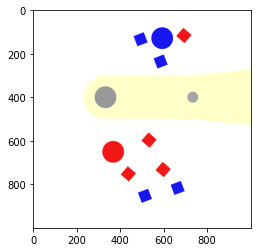

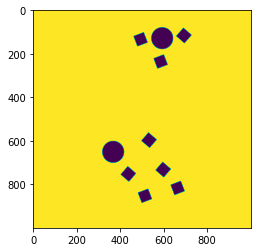

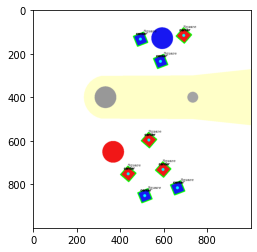

[[512, 851], [662, 815], [436, 751], [596, 731], [531, 596], [584, 235], [492, 133], [691, 116]]
[[23, 23, 241], [23, 23, 241], [241, 23, 23], [241, 23, 23], [241, 23, 23], [23, 23, 241], [23, 23, 241], [241, 23, 23]]
RED GREEN BLU


In [95]:
clientID = connect(19999)
retCode,sensorHandle=sim.simxGetObjectHandle(clientID,'Vision_sensor',sim.simx_opmode_blocking)

# Otteniamo l'immagine
retCode, resolution, img=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)

import cv2                      # opencv
import matplotlib.pyplot as plt # pyplot
import numpy as np 
       
image = np.array(img, dtype=np.uint8)
image.resize([resolution[1],resolution[0],3])
origninale_image= image
print(resolution)

#cv2.imshow('image', img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.imshow(image)
plt.show()

#convert image into greyscale mode
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#find threshold of the image
_, thrash = cv2.threshold(gray_image, 100, 250, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thrash, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
plt.imshow(thrash)
plt.show()
centers=[]
colori=[]
for contour in contours:
    shape = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour, True), True)
    if shape[0][0][0] != 0:
        x_cor = shape.ravel()[0]
        y_cor = shape.ravel()[1]

        if len(shape) ==4:
            #shape cordinates
            x,y,w,h = cv2.boundingRect(shape)

            #width:height
            aspectRatio = float(w)/h
            cv2.drawContours(image, [shape], 0, (0,255,0), 4)
            if aspectRatio >= 0.9 and aspectRatio <=1.1:
                cv2.putText(image, "Square", (x_cor, y_cor), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
                M = cv2.moments(contour)
                if M['m00'] != 0:
                    cx = int(M['m10']/M['m00'])
                    cy = int(M['m01']/M['m00'])
                    retCode, resolution, img2=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)
                    image2 = np.array(img2, dtype=np.uint8)
                    image2.resize([resolution[1],resolution[0],3])
                    (b, g, r) = image2[cy,cx]
                    colori.append([b, g, r])
                    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
                    cv2.circle(image, (cx, cy), 7, (0, 255, 255), -1)
                    cv2.putText(image, "center", (cx - 20, cy - 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
                    centers.append([cx,cy])
            else:
                cv2.putText(image, "Rectangle", (x_cor, y_cor), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,0,0))
                
    """    M = cv2.moments(contour)
      if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            retCode, resolution, img2=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)
            image2 = np.array(img2, dtype=np.uint8)
            image2.resize([resolution[1],resolution[0],3])
            (b, g, r) = image2[cy,cx]
            colori.append([b, g, r])
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
            cv2.circle(image, (cx, cy), 7, (0, 255, 255), -1)
            cv2.putText(image, "center", (cx - 20, cy - 20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            
        print(f"x: {cx} y: {cy}")"""  
        

    
        
plt.imshow(image)
plt.show()
print(centers)
print(colori)
print("RED GREEN BLU")



In [96]:
retCode,camera=sim.simxGetObjectHandle(clientID,'Vision_sensor',sim.simx_opmode_blocking)
res, posizioneCamera = sim.simxGetObjectPosition(clientID, camera, -1, sim.simx_opmode_blocking)
print("POSIZIONE CAMERA")
print(posizioneCamera)
res, posizioneCuboRosso = sim.simxGetObjectPosition(clientID, cuboRosso, -1, sim.simx_opmode_blocking)
print("POSIZIONE CUBO ROSSO")
print(posizioneCuboRosso)
xdiff = posizioneCamera[0] - posizioneCuboRosso[0]
ydiff = posizioneCamera[1] - posizioneCuboRosso[1]

print("diff from camera to target")
print(xdiff, ydiff)
n1 = 0
n2 = 0
m = 0
for c in centers:
    if colori[m][0]>200: #Se il cubo è rosso RGB--> R>200
        immXdiff = ((resolution[0]/2) - c[0]) * 0.001
        immYdiff = ((resolution[1]/2) - c[1]) * 0.001
        print("diff calculated from the image")
        print(immXdiff)
        print(immYdiff)
        posizioneTarget=[0,0,0]
        posizioneTarget[0]=posizioneCamera[0] + immXdiff
        posizioneTarget[1]=posizioneCamera[1] + immYdiff
        posizioneTarget[2]=0.05
        eulC=[0,0,0]
        targetP = posizioneTarget + eulC
        print(targetP)
        sq = sp.symbols(['q1','q2','q3','q4'])
        T2 = sp.Matrix([[sp.cos(sq[0] + sq[1] + sq[3]), -sp.sin(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.cos(sq[0]) + 0.4005*sp.cos(sq[0] + sq[1])], 
                       [sp.sin(sq[0] + sq[1] + sq[3]), sp.cos(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.sin(sq[0]) + 0.4005*sp.sin(sq[0]+ sq[1])], 
                       [0, 0, 1, 0.234 - sq[2]], [0, 0, 0, 1]])

        # inviamo alla posa di destinazione
        d2 = targetP
        D2 = matrixFromPose(d2)
        q = sp.nsolve(T2-D2, sq, [0.1, 0.1, 0.1, 0.1], prec=6)
        #print('q')
        #print(q)
        clientID = connect(19999)
        # spostiamo il robot nella posizione
        retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_blocking)
        retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_blocking)
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
        retCode = sim.simxSetJointTargetPosition(clientID, joint4, q[3], sim.simx_opmode_blocking)
        time.sleep(1)
        # abbassiamo l'attuatore
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2], sim.simx_opmode_blocking)
        time.sleep(1)
        # attiviamo l'end effector
        setEffector(1)
        time.sleep(1)
        # alziamo l'attuatore
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
        time.sleep(1)
        # andiamo alla posizione per i cubi rossi
        retCode = sim.simxSetJointTargetPosition(clientID, joint1, 0, sim.simx_opmode_blocking)
        retCode = sim.simxSetJointTargetPosition(clientID, joint2, 0.5, sim.simx_opmode_blocking)
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
        time.sleep(1)
        # abbassiamo il cubo
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2] - (n1*0.05), sim.simx_opmode_blocking)
        time.sleep(1)
        # Disattiviamo l'attuatore
        time.sleep(1)
        setEffector(0)
        # e lo alziamo
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
        n1 = n1+1
        print("Ho posato un cubo rosso nella sua posizione")
    else:
        immXdiff = ((resolution[0]/2) - c[0]) * 0.001
        immYdiff = ((resolution[1]/2) - c[1]) * 0.001
        print("diff calculated from the image")
        print(immXdiff)
        print(immYdiff)
        posizioneTarget=[0,0,0]
        posizioneTarget[0]=posizioneCamera[0] + immXdiff
        posizioneTarget[1]=posizioneCamera[1] + immYdiff
        posizioneTarget[2]=0.05
        eulC=[0,0,0]
        targetP = posizioneTarget + eulC
        print(targetP)
        sq = sp.symbols(['q1','q2','q3','q4'])
        T2 = sp.Matrix([[sp.cos(sq[0] + sq[1] + sq[3]), -sp.sin(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.cos(sq[0]) + 0.4005*sp.cos(sq[0] + sq[1])], 
                       [sp.sin(sq[0] + sq[1] + sq[3]), sp.cos(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.sin(sq[0]) + 0.4005*sp.sin(sq[0]+ sq[1])], 
                       [0, 0, 1, 0.234 - sq[2]], [0, 0, 0, 1]])

        # inviamo alla posa di destinazione
        d2 = targetP
        D2 = matrixFromPose(d2)
        q = sp.nsolve(T2-D2, sq, [0.1, 0.1, 0.1, 0.1], prec=6)
        #print('q')
        #print(q)
        clientID = connect(19999)
        # spostiamo il robot nella posizione
        retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_blocking)
        retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_blocking)
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
        retCode = sim.simxSetJointTargetPosition(clientID, joint4, q[3], sim.simx_opmode_blocking)
        time.sleep(1)
        # abbassiamo l'attuatore
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2], sim.simx_opmode_blocking)
        time.sleep(1)
        # attiviamo l'end effector
        setEffector(1)
        time.sleep(1)
        # alziamo l'attuatore
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
        time.sleep(1)
        # andiamo alla posizione per i cubi blu
        retCode = sim.simxSetJointTargetPosition(clientID, joint1, 0, sim.simx_opmode_blocking)
        retCode = sim.simxSetJointTargetPosition(clientID, joint2, 0, sim.simx_opmode_blocking)
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
        time.sleep(1)
        # abbassiamo il cubo
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2] - (n2*0.05), sim.simx_opmode_blocking)
        time.sleep(1)
        # Disattiviamo l'attuatore
        time.sleep(1)
        setEffector(0)
        # e lo alziamo
        retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
        n2 = n2+1
        print("Ho posato un cubo blu nella sua posizione")
    m=m+1

POSIZIONE CAMERA
[0.699999988079071, -0.10000000149011612, 1.0]
POSIZIONE CUBO ROSSO
[0.6676894426345825, -0.19687122106552124, 0.024999920278787613]
diff from camera to target
0.032310545444488525 0.09687121957540512
diff calculated from the image
-0.012
-0.35100000000000003
[0.687999988079071, -0.45100000149011615, 0.05, 0, 0, 0]
conectado a 19999
Ho posato un cubo blu nella sua posizione
diff calculated from the image
-0.162
-0.315
[0.537999988079071, -0.4150000014901161, 0.05, 0, 0, 0]
conectado a 19999
Ho posato un cubo blu nella sua posizione
diff calculated from the image
0.064
-0.251
[0.7639999880790711, -0.3510000014901161, 0.05, 0, 0, 0]
conectado a 19999
Ho posato un cubo rosso nella sua posizione
diff calculated from the image
-0.096
-0.231
[0.6039999880790711, -0.3310000014901161, 0.05, 0, 0, 0]
conectado a 19999
Ho posato un cubo rosso nella sua posizione
diff calculated from the image
-0.031
-0.096
[0.668999988079071, -0.19600000149011612, 0.05, 0, 0, 0]
conectado a 1999